<a href="https://colab.research.google.com/github/Veenamra-0246/GETPOS/blob/deployment-development/Amazon_Product_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [8]:
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('ratings_Electronics.csv',names=columns)

In [9]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [10]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [11]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25850 entries, 0 to 25849
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     25850 non-null  object 
 1   productId  25850 non-null  object 
 2   ratings    25849 non-null  float64
dtypes: float64(1), object(2)
memory usage: 606.0+ KB


In [12]:
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  25850
Number of columns:  3


In [13]:
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [14]:
electronics_df1=electronics_df.iloc[:50000,0:]

In [15]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25850 entries, 0 to 25849
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     25850 non-null  object 
 1   productId  25850 non-null  object 
 2   ratings    25849 non-null  float64
dtypes: float64(1), object(2)
memory usage: 606.0+ KB


In [16]:
electronics_df1['ratings'].describe().transpose()

count    25849.000000
mean         3.974661
std          1.398456
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [17]:
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [18]:
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      1
dtype: int64


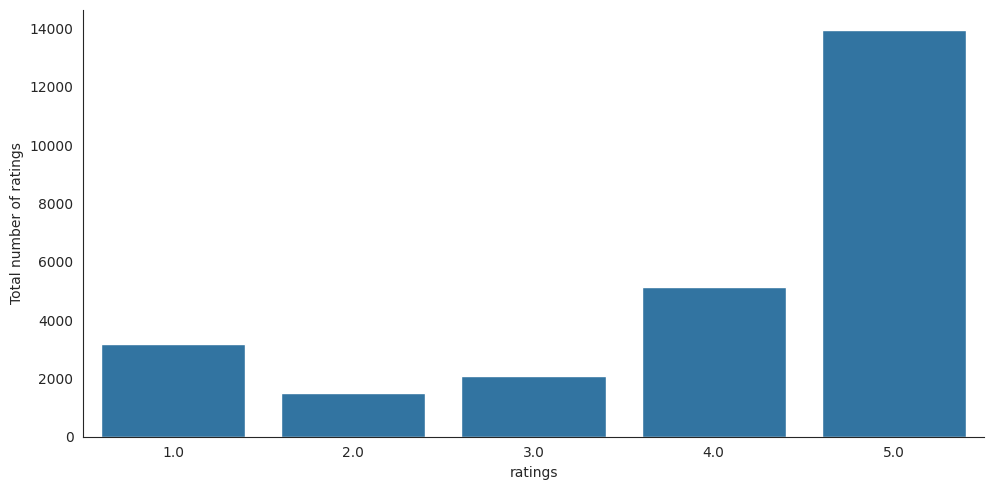

In [21]:
with sns.axes_style('white'):
    g = sns.catplot(x="ratings", data=electronics_df1, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

In [22]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  24811
Number of unique product in Raw data =  2216


In [23]:
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A1ISUNUWG0K02V    9
A243HY69GIAHFI    9
A3A15L96IYUO6V    8
A1ORUSHRRG0VWN    8
A6ZPLVAUQ6695     8
A1WVMDRJU19AFD    8
A11D1KHM7DVOQK    7
AT8TIN5JKHO2V     7
AEE2GJR0VF6R7     7
A3PLX6PTM2ERKL    7
dtype: int64


In [30]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=5].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 207
Number of unique users in the final data =  34
Number of unique products in the final data =  34


In [31]:
final_ratings_matrix = electronics_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,1400501466,1400501520,1400501776,140053271X,1400599997,1400698987,B000000O2F,B000000O48,B000001OKH,B000001OL6,...,B00001QHVT,B00001RMCY,B00001RMDH,B00001RMDT,B00001RME8,B00001U0SK,B00001W0D1,B00001W0D4,B00001W0DD,B00001W0DG
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
A14JBDSWKPKTZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BAT4NZAP6B07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1G9L2BT6DTE95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (34, 163)


In [33]:
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  207
possible_num_of_ratings =  5542
density: 3.74%


In [34]:
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
12530,A1G9L2BT6DTE95,B00000J49V,5.0
10004,A2HDTOF8222KN3,B00000J1F3,5.0
11018,A6FIAB28IS79,B00000J1UQ,5.0
12516,A2AEZQ3DGBBLPR,B00000J49I,2.0
12407,A1NVD0TKNS1GT5,B00000J47A,2.0


In [35]:
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,1400501466,1
1,1400501520,1
2,1400501776,1
3,140053271X,1
4,B000000O2F,1
5,B000001OKH,1
6,B000001OL6,1
7,B000001OMN,1
8,B000001OMV,1
9,B00000DM9M,1


In [36]:
#Sort the products on recommendation score
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])

#Generate a recommendation rank based upon score
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

#Get the top 5 recommendations
popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,productId,score,rank
25,B00000J3II,4,1.0
27,B00000J3Q1,3,2.0
40,B00000J4FS,3,3.0
80,B00000JSGF,3,4.0
118,B00001W0DD,3,5.0


In [37]:
def recommend(user_id):
    user_recommendations = popularity_recommendations

    #Add user_id column for which the recommendations are being generated
    user_recommendations['userId'] = user_id

    #Bring user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [38]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))
    print("\n")

The list of recommendations for the userId: 10

     userId   productId  score  rank
25       10  B00000J3II      4   1.0
27       10  B00000J3Q1      3   2.0
40       10  B00000J4FS      3   3.0
80       10  B00000JSGF      3   4.0
118      10  B00001W0DD      3   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
25      100  B00000J3II      4   1.0
27      100  B00000J3Q1      3   2.0
40      100  B00000J4FS      3   3.0
80      100  B00000JSGF      3   4.0
118     100  B00001W0DD      3   5.0


The list of recommendations for the userId: 150

     userId   productId  score  rank
25      150  B00000J3II      4   1.0
27      150  B00000J3Q1      3   2.0
40      150  B00000J4FS      3   3.0
80      150  B00000JSGF      3   4.0
118     150  B00001W0DD      3   5.0




In [39]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,12530,A1G9L2BT6DTE95,B00000J49V,5.0
1,10004,A2HDTOF8222KN3,B00000J1F3,5.0
2,11018,A6FIAB28IS79,B00000J1UQ,5.0
3,12516,A2AEZQ3DGBBLPR,B00000J49I,2.0
4,12407,A1NVD0TKNS1GT5,B00000J47A,2.0


In [40]:
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,1400501466,1400501520,1400501776,140053271X,1400599997,1400698987,B000000O2F,B000000O48,B000001OKH,B000001OL6,...,B00001QHVT,B00001RMCY,B00001RMDH,B00001RMDT,B00001RME8,B00001U0SK,B00001W0D1,B00001W0D4,B00001W0DD,B00001W0DG
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
A14JBDSWKPKTZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BAT4NZAP6B07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1G9L2BT6DTE95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (34, 163)


In [42]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400501466,1400501520,1400501776,140053271X,1400599997,1400698987,B000000O2F,B000000O48,B000001OKH,B000001OL6,...,B00001RMCY,B00001RMDH,B00001RMDT,B00001RME8,B00001U0SK,B00001W0D1,B00001W0D4,B00001W0DD,B00001W0DG,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0
A14JBDSWKPKTZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1BAT4NZAP6B07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A1G9L2BT6DTE95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0,3
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [43]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,1400501466,1400501520,1400501776,140053271X,1400599997,1400698987,B000000O2F,B000000O48,B000001OKH,B000001OL6,...,B00001QHVT,B00001RMCY,B00001RMDH,B00001RMDT,B00001RME8,B00001U0SK,B00001W0D1,B00001W0D4,B00001W0DD,B00001W0DG
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
pivot_csr = csr_matrix(pivot_df.values)


In [50]:
U, sigma, Vt = svds(pivot_csr, k=10)

In [51]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 2.22044605e-16  4.61687491e-17 -8.77810636e-17  1.95614608e-17
  -9.69345749e-17  6.73052676e-18 -3.61674515e-17 -5.83756684e-18
  -1.95155621e-18  1.35229416e-17]
 [ 2.26892644e-16  2.22044605e-16 -6.97147440e-16  2.16254942e-15
   8.33912198e-16  7.50442045e-17  4.55570247e-16  5.21467914e-17
   3.93204530e-17 -5.79018191e-17]
 [ 5.65368080e-16 -2.34757013e-03  6.50207404e-02  1.31210172e-01
  -1.03898731e-01 -2.53409642e-02  2.12656360e-01 -3.52310081e-02
   2.84711126e-02 -7.88167092e-02]
 [-9.86483819e-15 -8.35363310e-03  3.02093699e-01 -3.28873928e-01
   2.45527428e-02 -5.19913192e-02  1.83725172e-01 -1.62431072e-01
   3.62013484e-02 -1.14789308e-01]
 [-1.65151991e-15 -3.96482772e-04  4.95562101e-02 -8.16355156e-02
   1.65349488e-02  9.59776970e-01  8.07705823e-02 -1.57426126e-02
  -1.06966012e-01 -3.15002510e-02]
 [-2.19337415e-15 -2.72770784e-03  1.71632810e-01  1.04529832e-01
   2.66248434e-01 -2.49577282e-02 -3.19759560e-02  1.22311929e-01
  -1.0468

In [52]:
print('Sigma: \n',sigma)

Sigma: 
 [11.74443324 11.96765302 12.06089647 12.10983864 12.4606087  13.11789425
 13.36149384 14.14947692 14.55636124 16.04695155]


In [53]:
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[11.74443324  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         11.96765302  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         12.06089647  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         12.10983864  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         12.4606087   0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         13.11789425
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  13.36149384  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         14.14947692  0.          0.        ]
 [ 0.          0.          0.        

In [54]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 0.00000000e+00 -6.68857719e-17 -6.68857719e-17 ...  7.56254816e-17
  -9.25278541e-15 -2.51987593e-15]
 [-7.88659118e-17 -2.22044605e-16 -7.88659118e-17 ...  1.54311791e-17
  -7.10240676e-03 -2.09405297e-03]
 [ 1.22639406e-17  8.45677695e-18  1.72421351e-29 ... -2.91126166e-17
   2.41880091e-01  7.51421007e-02]
 ...
 [-4.86561254e-17 -4.09828421e-17 -7.09919520e-17 ... -1.65025658e-18
  -1.16643414e-01 -3.44389561e-02]
 [ 1.33035532e-16  4.95480393e-17  2.94531414e-17 ... -5.36275838e-19
   1.09314415e-01  7.46093363e-03]
 [ 4.77825071e-17  1.21430643e-17  3.41257118e-18 ...  3.37084375e-18
  -1.69089701e-01 -2.14600214e-02]]


In [55]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,1400501466,1400501520,1400501776,140053271X,1400599997,1400698987,B000000O2F,B000000O48,B000001OKH,B000001OL6,...,B00001QHVT,B00001RMCY,B00001RMDH,B00001RMDT,B00001RME8,B00001U0SK,B00001W0D1,B00001W0D4,B00001W0DD,B00001W0DG
0,-3.504588e-32,-2.924179e-31,-1.297234e-31,-8.825596e-32,4.736738e-18,-1.807715e-31,-4.822553e-16,1.256894e-31,-1.414567e-15,-6.028191e-16,...,-9.952733e-18,-2.291579e-16,-4.846900e-16,2.831928e-32,8.675255e-17,-6.697477e-18,-1.735463e-16,2.819759e-31,-4.030495e-16,-1.301597e-16
1,2.945993e-30,2.414405e-30,3.200911e-30,4.862044e-30,1.966524e-16,2.057644e-30,-4.927846e-16,-1.853770e-31,-1.445452e-15,-6.159808e-16,...,-8.065997e-16,-2.367807e-16,5.848214e-15,5.628410e-31,2.161071e-15,-5.446542e-16,-3.295169e-15,2.646399e-31,-1.026041e-14,-2.471377e-15
2,2.169668e-16,2.346288e-16,3.566097e-16,5.788214e-16,1.398640e-02,2.053154e-16,-7.646095e-16,5.996875e-17,-1.954534e-15,-8.816497e-16,...,-7.805619e-02,-2.669274e-01,1.566261e-02,1.511099e-17,-1.955199e-01,-5.153705e-02,1.205913e-01,-7.821849e-18,-1.226838e-02,9.044346e-02
3,-3.088187e-16,-2.922328e-16,-4.279876e-16,-6.378265e-16,-2.870551e-02,-1.738347e-16,-1.662408e-15,1.873640e-16,-3.888047e-15,-1.851670e-15,...,4.340089e-02,-2.505633e-02,-4.361208e-02,-1.206814e-16,-4.526238e-01,3.255333e-02,1.109681e+00,-1.735463e-16,2.875571e+00,8.322609e-01
4,-1.868838e-15,-1.718823e-15,-1.732290e-15,-1.594200e-15,2.069554e-01,-2.966466e-15,-8.903980e-16,7.563854e-17,-2.484959e-15,-1.120607e-15,...,-5.273973e-02,-1.338918e-01,-1.247446e-02,-5.775812e-17,-8.023581e-02,-3.437648e-02,3.787155e-02,-1.661964e-17,1.628899e-01,2.840366e-02


In [56]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0
    user_idx = userID-1
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [57]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00000JI3H                  0.0          2.042435
B00000J4VK                  0.0          1.572786
B00000J1TX                  0.0          1.128828
B00000JDK0                  0.0          0.916804
B00000JI2D                  0.0          0.840053


In [58]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00001O2YP                  0.0          1.572036
B00000K1SD                  0.0          1.572036
B00001RMDH                  0.0          1.572036
B00000J4O2                  0.0          1.257629
B00000J3Q7                  0.0          0.943221


In [59]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00001P4WE                  0.0          1.044244
B00000J4GI                  0.0          1.044244
B00001P4X0                  0.0          1.044244
B00000K4KU                  0.0          1.016916
B00000J3II                  0.0          0.858335


In [60]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,1400501466,1400501520,1400501776,140053271X,1400599997,1400698987,B000000O2F,B000000O48,B000001OKH,B000001OL6,...,B00001QHVT,B00001RMCY,B00001RMDH,B00001RMDT,B00001RME8,B00001U0SK,B00001W0D1,B00001W0D4,B00001W0DD,B00001W0DG
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
A14JBDSWKPKTZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BAT4NZAP6B07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1G9L2BT6DTE95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
1400501466    0.147059
1400501520    0.147059
1400501776    0.147059
140053271X    0.117647
1400599997    0.029412
dtype: float64

In [62]:
# Predicted ratings
preds_df.head()

productId,1400501466,1400501520,1400501776,140053271X,1400599997,1400698987,B000000O2F,B000000O48,B000001OKH,B000001OL6,...,B00001QHVT,B00001RMCY,B00001RMDH,B00001RMDT,B00001RME8,B00001U0SK,B00001W0D1,B00001W0D4,B00001W0DD,B00001W0DG
0,-3.504588e-32,-2.924179e-31,-1.297234e-31,-8.825596e-32,4.736738e-18,-1.807715e-31,-4.822553e-16,1.256894e-31,-1.414567e-15,-6.028191e-16,...,-9.952733e-18,-2.291579e-16,-4.846900e-16,2.831928e-32,8.675255e-17,-6.697477e-18,-1.735463e-16,2.819759e-31,-4.030495e-16,-1.301597e-16
1,2.945993e-30,2.414405e-30,3.200911e-30,4.862044e-30,1.966524e-16,2.057644e-30,-4.927846e-16,-1.853770e-31,-1.445452e-15,-6.159808e-16,...,-8.065997e-16,-2.367807e-16,5.848214e-15,5.628410e-31,2.161071e-15,-5.446542e-16,-3.295169e-15,2.646399e-31,-1.026041e-14,-2.471377e-15
2,2.169668e-16,2.346288e-16,3.566097e-16,5.788214e-16,1.398640e-02,2.053154e-16,-7.646095e-16,5.996875e-17,-1.954534e-15,-8.816497e-16,...,-7.805619e-02,-2.669274e-01,1.566261e-02,1.511099e-17,-1.955199e-01,-5.153705e-02,1.205913e-01,-7.821849e-18,-1.226838e-02,9.044346e-02
3,-3.088187e-16,-2.922328e-16,-4.279876e-16,-6.378265e-16,-2.870551e-02,-1.738347e-16,-1.662408e-15,1.873640e-16,-3.888047e-15,-1.851670e-15,...,4.340089e-02,-2.505633e-02,-4.361208e-02,-1.206814e-16,-4.526238e-01,3.255333e-02,1.109681e+00,-1.735463e-16,2.875571e+00,8.322609e-01
4,-1.868838e-15,-1.718823e-15,-1.732290e-15,-1.594200e-15,2.069554e-01,-2.966466e-15,-8.903980e-16,7.563854e-17,-2.484959e-15,-1.120607e-15,...,-5.273973e-02,-1.338918e-01,-1.247446e-02,-5.775812e-17,-8.023581e-02,-3.437648e-02,3.787155e-02,-1.661964e-17,1.628899e-01,2.840366e-02


In [63]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
1400501466   -2.173378e-16
1400501520   -1.535465e-16
1400501776   -7.295292e-17
140053271X    2.380395e-17
1400599997    2.173249e-02
dtype: float64

In [64]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(163, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400501466,0.147059,-2.173378e-16,0
1400501520,0.147059,-1.535465e-16,1
1400501776,0.147059,-7.295292e-17,2
140053271X,0.117647,2.380395e-17,3
1400599997,0.029412,2.173249e-02,4


In [65]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.07709 



In [66]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00000K4BB                  0.0          2.048045
B00000K4B2                  0.0          2.048045
B00000K3RK                  0.0          2.048045
B00000JSGF                  0.0          0.032698
B00001P4XA                  0.0          0.026665
